In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from utils import *

def generate_synthetic_image(size=100, radius=20, center=(50, 50)):
    """
    Generate a synthetic binary image with a circle in the center.
    """
    image = np.zeros((size, size))
    rr, cc = np.ogrid[:size, :size]
    circle = (rr - center[0]) ** 2 + (cc - center[1]) ** 2 <= radius ** 2
    image[circle] = 1
    return image

def plot_snake(image, snake, title="Snake Evolution"):
    """
    Plot the snake on the image.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='gray')
    plt.plot(snake[:, 1], snake[:, 0], '-r', linewidth=2)
    plt.scatter(snake[:, 1], snake[:, 0], c='r', s=10)
    plt.title(title)
    plt.axis('off')
    plt.show()

def static_experiment(image, alpha, beta, gamma, iterations, w_edge, w_line=0.0, w_term=0.0, w_scale=0.0, sigma=2.0,num_points=30):
    """
    Perform the static experiment: evolve the snake on a single image.
    """
    # Initialize snake with fewer points
    t = np.linspace(0, 2 * np.pi, num_points)
    x = 50 + 30 * np.cos(t)
    y = 50 + 30 * np.sin(t)
    initial_snake_points = np.array([y, x]).T
    snake = initialize_snake_contour(initial_snake_points, num_points=30)
    
    # Compute external energy (focus on edge energy)
    external_energy = compute_external_energy(image, w_line, w_edge, w_term, w_scale, sigma)
    
    # Precompute the inverse matrix for internal energy
    n_points = snake.shape[0]
    inv_P = create_internal_matrix(n_points, alpha, beta, gamma)
    
    # Visualize initial snake
    plot_snake(image, snake, title="Static Experiment - Initial Snake")
    
    # Evolve the snake
    for i in range(iterations):
        # Get external force
        external_force = get_external_force(external_energy, snake)

        # Evolve snake
        snake = evolve_snake(snake, inv_P, external_force, gamma)

        # Enforce boundary conditions
        snake[:, 0] = np.clip(snake[:, 0], 0, image.shape[0] - 1)
        snake[:, 1] = np.clip(snake[:, 1], 0, image.shape[1] - 1)

        # Visualize every 20 iterations
        if i % 20 == 0 or i == iterations - 1:
            plot_snake(image, snake, title=f"Static Experiment - Iteration {i}")

    return snake

def scale_space_experiment(complex_image, alpha, beta, gamma, iterations, w_edge, w_scale, sigma):
    """
    Perform the scale-space energy experiment: evolve the snake on a more complex image.
    """
    # Initialize snake with fewer points
    t = np.linspace(0, 2 * np.pi, num_points)
    x = 50 + 30 * np.cos(t)
    y = 50 + 30 * np.sin(t)
    initial_snake_points = np.array([y, x]).T
    snake_complex = initialize_snake_contour(initial_snake_points, num_points=30)
    
    # Compute external energy with scale-space
    external_energy_complex = compute_external_energy(complex_image, w_line=0.0, w_edge=w_edge, w_term=0.0, w_scale=w_scale, sigma=sigma)
    
    # Precompute the inverse matrix for internal energy
    n_points_complex = snake_complex.shape[0]
    inv_P_complex = create_internal_matrix(n_points_complex, alpha, beta, gamma)
    
    # Visualize initial snake
    plot_snake(complex_image, snake_complex, title="Scale-Space Experiment - Initial Snake")
    
    # Evolve the snake
    for i in range(iterations):
        # Get external force
        external_force_complex = get_external_force(external_energy_complex, snake_complex)

        # Evolve snake
        snake_complex = evolve_snake(snake_complex, inv_P_complex, external_force_complex, gamma)

        # Enforce boundary conditions
        snake_complex[:, 0] = np.clip(snake_complex[:, 0], 0, complex_image.shape[0] - 1)
        snake_complex[:, 1] = np.clip(snake_complex[:, 1], 0, complex_image.shape[1] - 1)

        # Visualize every 50 iterations
        if i % 50 == 0 or i == iterations - 1:
            plot_snake(complex_image, snake_complex, title=f"Scale-Space Experiment - Iteration {i}")

    return snake_complex





gen	nevals
0  	50    
1  	41    
2  	35    
3  	34    
4  	32    
5  	34    
6  	41    
7  	41    
8  	35    
9  	36    
10 	33    
11 	42    
12 	38    
13 	40    
14 	38    
15 	42    
16 	41    
17 	37    
18 	40    
19 	39    
20 	37    
Best parameters found: [0.3998794996112571, 0.18293359580932986, 0.5854550971568848, -4.834810061836998, 0.20975264689045595, 0.17813239075223278, 0.13658822579137533, 3.6881726690053798, 63.08480963591913, 158.07986893008288]


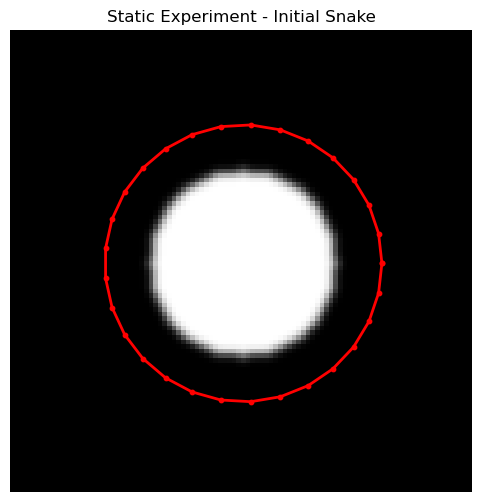

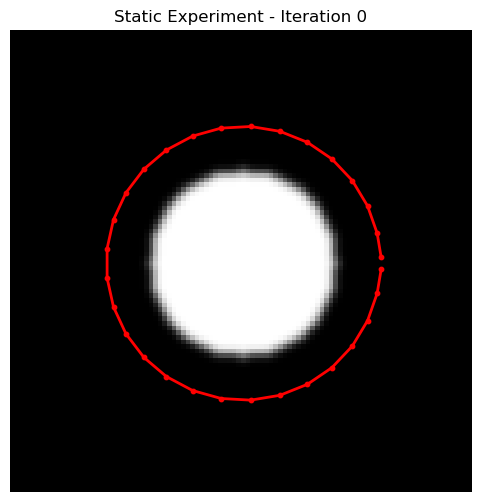

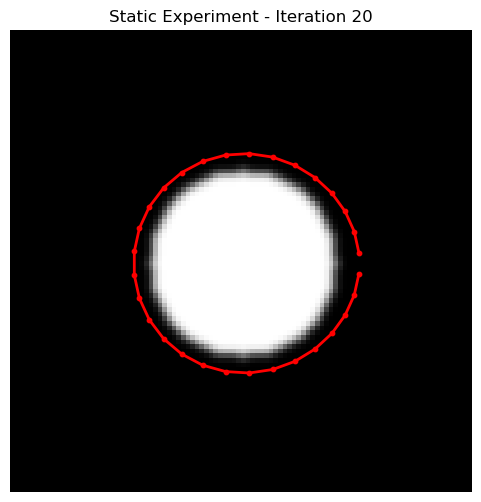

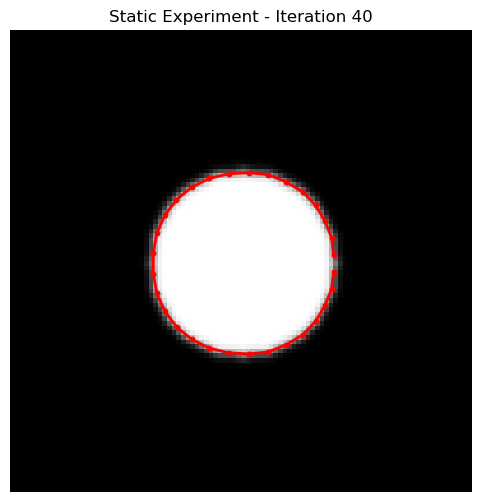

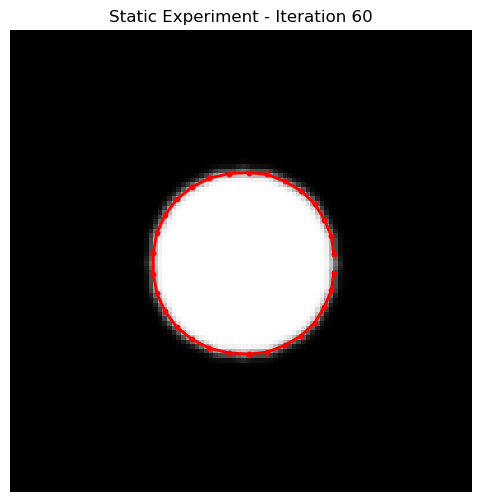

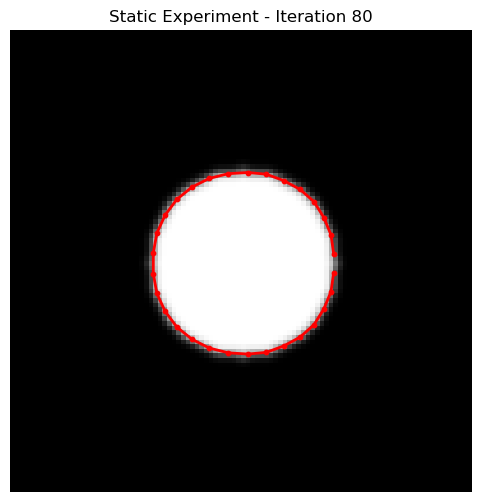

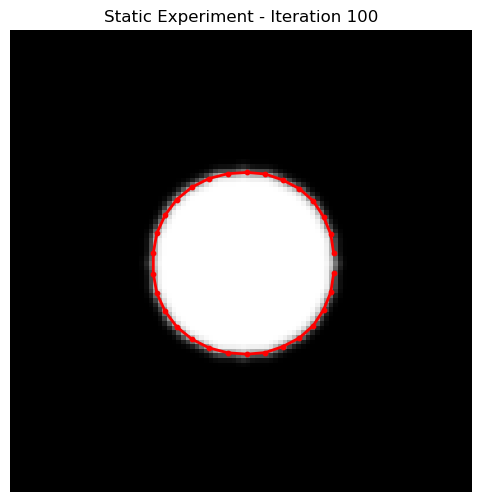

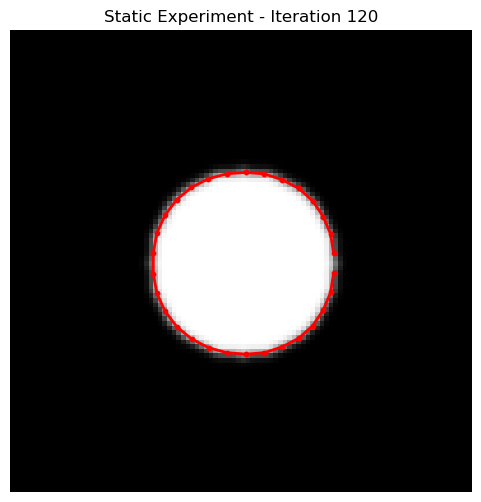

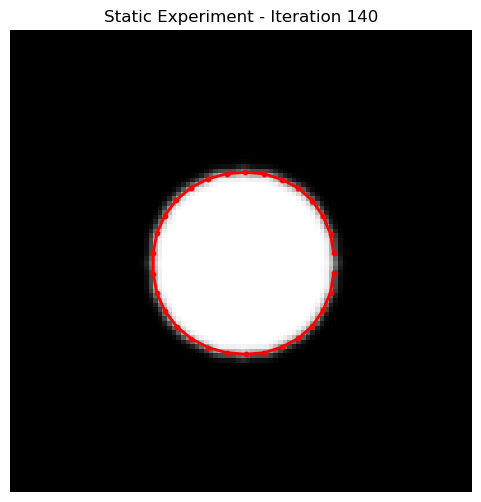

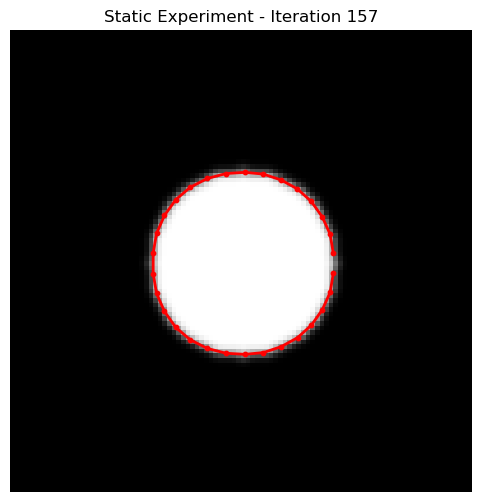

gen	nevals
0  	50    
1  	37    
2  	44    
3  	38    
4  	42    
5  	42    
6  	43    
7  	40    
8  	45    
9  	43    
10 	37    
11 	37    
12 	42    
13 	35    
14 	39    
15 	33    
16 	38    
17 	42    
18 	37    
19 	44    
20 	40    
Best parameters found: [0.42083252272739513, 0.03172019391374643, 0.5477237314628323, -4.83163169534237, -0.5032512474738378, 0.0698783892759911, -0.9816276702029643, 1.3342529272547636, 52.883187597299404, 225.83119083708107]


TypeError: scale_space_experiment() got an unexpected keyword argument 'num_points'

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import map_coordinates
from deap import base, creator, tools, algorithms
import random

# Importing functions from the utils file (which contains snake-related utility functions)
from utils import (
    initialize_snake_contour, compute_external_energy,
    get_external_force, create_internal_matrix, evolve_snake
)

# Define fitness function to evaluate snake performance
def evaluate_snake(params, image, static=True):
    alpha, beta, gamma, w_edge, w_line, w_term, w_scale, sigma, num_points, iterations = params

    # Ensure num_points is an integer
    num_points = int(num_points)

    # Create initial snake points based on the fixed initial radius of 30
    t = np.linspace(0, 2 * np.pi, num_points)
    x = 50 + 30 * np.cos(t)
    y = 50 + 30 * np.sin(t)
    initial_snake_points = np.array([y, x]).T

    # Initialize snake
    snake = initialize_snake_contour(initial_snake_points, num_points=num_points)

    # Compute external energy
    if static:
        external_energy = compute_external_energy(image, w_line, w_edge, w_term, 0.0, sigma)
    else:
        external_energy = compute_external_energy(image, w_line, w_edge, w_term, w_scale, sigma)

    # Precompute the inverse matrix for internal energy
    n_points = snake.shape[0]
    inv_P = create_internal_matrix(n_points, alpha, beta, gamma)

    # Evolve the snake
    for _ in range(int(iterations)):
        external_force = get_external_force(external_energy, snake)
        snake = evolve_snake(snake, inv_P, external_force, gamma)
        snake[:, 0] = np.clip(snake[:, 0], 0, image.shape[0] - 1)
        snake[:, 1] = np.clip(snake[:, 1], 0, image.shape[1] - 1)

    # Calculate overlap with object (higher overlap means better fit)
    object_mask = image > 0.5
    snake_mask = np.zeros_like(image, dtype=bool)
    snake_mask[snake[:, 0].astype(int), snake[:, 1].astype(int)] = True
    overlap = np.sum(object_mask & snake_mask)

    # Calculate total external energy along the snake
    snake_external_energy = np.sum(map_coordinates(external_energy, [snake[:, 0], snake[:, 1]], order=1))

    # Fitness combines overlap and total external energy to maximize both
    fitness = overlap + 0.5 * snake_external_energy  # Adjust weight (0.5) as necessary to balance
    return fitness,


# Define function for running a genetic algorithm using DEAP
def run_genetic_algorithm(static=True):
    # Create GA setup using DEAP
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    # Define attributes (parameters to optimize)
    toolbox.register("alpha", random.uniform, 0.1, .2)
    toolbox.register("beta", random.uniform, 0.1, .5)
    toolbox.register("gamma", random.uniform, 0.01, 1)
    toolbox.register("w_edge", random.uniform, 0.5, 3.0)
    toolbox.register("w_line", random.uniform, 0.0, 1.0)
    toolbox.register("w_term", random.uniform, 0.0, 1.0)
    toolbox.register("w_scale", random.uniform, 0.0, 2.0)
    toolbox.register("sigma", random.uniform, 1.0, 5.0)
    toolbox.register("num_points", random.randint, 20, 50)
    toolbox.register("iterations", random.randint, 100, 300)  # Adding iterations as a parameter to optimize

    # Create individual and population
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.alpha, toolbox.beta, toolbox.gamma, toolbox.w_edge,
                      toolbox.w_line, toolbox.w_term, toolbox.w_scale, toolbox.sigma, toolbox.num_points, toolbox.iterations), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register evaluation, mating, mutation, and selection functions
    image = generate_synthetic_image()  # Generate synthetic image
    image = ndimage.gaussian_filter(image, sigma=1.0)  # Smooth the image

    toolbox.register("evaluate", evaluate_snake, image=image, static=static)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Genetic Algorithm parameters
    population_size = 50
    generations = 20
    crossover_probability = 0.7
    mutation_probability = 0.2

    # Run GA
    population = toolbox.population(n=population_size)
    algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability,
                        ngen=generations, verbose=True)

    # Extract and plot the best result
    best_individual = tools.selBest(population, k=1)[0]
    print("Best parameters found:", best_individual)

    # Plot the final snake using the best parameters
    if static:
        final_snake = static_experiment(
            image=image,
            alpha=best_individual[0],
            beta=best_individual[1],
            gamma=best_individual[2],
            iterations=int(best_individual[9]),  # Use optimized number of iterations
            w_edge=best_individual[3],
            w_line=best_individual[4],
            w_term=best_individual[5],
            w_scale=0.0,  # Set w_scale to 0 for static experiment
            sigma=best_individual[7],
            num_points=int(best_individual[8])  # Use optimized number of points, ensure it's an integer
        )
    else:
        # Perform scale-space energy experiment
        complex_image = generate_synthetic_image(size=200, radius=40, center=(100, 100))
        complex_image = ndimage.gaussian_filter(complex_image, sigma=2.0)
        complex_image += 0.2 * np.random.randn(*complex_image.shape)
        complex_image = (complex_image - np.min(complex_image)) / (np.max(complex_image) - np.min(complex_image) + 1e-8)

        scale_snake = scale_space_experiment(
            complex_image=complex_image,
            alpha=best_individual[0],
            beta=best_individual[1],
            gamma=best_individual[2],
            iterations=int(best_individual[9]),  # Use optimized number of iterations
            w_edge=best_individual[3],
            w_scale=best_individual[6],
            sigma=best_individual[7],
            num_points=int(best_individual[8])  # Use optimized number of points, ensure it's an integer
        )

run_genetic_algorithm(static=True)  # Run GA for static experiment
